In [461]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import json
import shutil
import math


#pip install analytic_wfm
from analytic_wfm.peakdetect import *
import cloudpickle
from datetime import datetime
import time

from sklearn.cluster import KMeans, k_means
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [333]:
# Afficher 1000 colonnes dans une DataFrame
pd.set_option('display.max_columns', 1000)

In [ ]:
# Copie des fichiers .event pour aide export en .txt
copy_event_file("..\Millau\Resultats")
# copy_event_file("..\Normandie")

In [ ]:
# Sélection des meilleurs signaux pour chacun des camions représentés par un fichier .txt
trucks_millau = select_all_best_signal('../Millau/Resultats/All_event', backup_path="backup/backup_trucks_millau.json")
# trucks_normandie = select_all_best_signal('../Normandie/All_event', backup_path="backup/backup_trucks_normandie.json")

In [ ]:
# Récupération des csv contenant les informations de charges
millau = pd.read_csv('../Millau/Resultats/Fichiers Excel/millau_df_model.csv', index_col=0)
# normandie = pd.read_csv('../Normandie/Fichiers Excel/normandie_df_model.csv', index_col=0)

In [ ]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau = find_trucks_in_csv(trucks_millau, millau, "backup_trucks_coor_millau.json")
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json

In [ ]:
# Création des class Signal
trucks_sig_millau = create_signal_instance(trucks_coor_millau, filename="class_trucks_millau.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [ ]:
# Création DataFrame global Millau /!\ Limite à 11 pics max (8 essieux)
all_df = pd.DataFrame()
for key, value in trucks_sig_millau.items():
    if (len(value.peaks) > 4) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df = pd.concat([all_df, value], sort=True)
all_df = all_df.reset_index(drop=True).sort_index()

In [ ]:
# Remplacer 'max' par 1
all_df.replace(to_replace='max', value=1, inplace=True)

# Remplacer 'min' par 2
all_df.replace(to_replace='min', value=2, inplace=True)

In [ ]:
all_df = pd.concat([timestamp_dummies(all_df['name']), all_df], axis=1)
all_df.drop(['name'], axis=1, inplace = True)

In [362]:
#Normalisation des données
all_df_norm = all_df.apply(lambda x: (x-np.mean(x))/(1e-10+np.std(x)))

In [ ]:
# Complétion NaN
all_df.fillna(0, inplace=True)

## Test de modèle

### Découpage train/test

In [ ]:
loads = list_multiple_var('load_', var_to=8)
Y = all_df[loads]
X = all_df.drop(loads, axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Clustering

In [97]:
kms = KMeans(init='k-means++', n_clusters=4, random_state=42)
kms.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [98]:
predicted = kms.predict(X_train)

#### Données liées

In [ ]:
# Centroïdes
print("Centroïdes:")
print(kms.cluster_centers_)
# Inertie
print("Inertie:")
print(kms.inertia_)
#Distance entre les 2 centroïdes
print("Distance centroïdes:")
print(sum((kms.cluster_centers_[0] - kms.cluster_centers_[1])**2))
#label
kms.label_

#### Affichage graphique

In [375]:
k_ms = k_means(X, 4)
clusters = pd.DataFrame(k_ms[1])

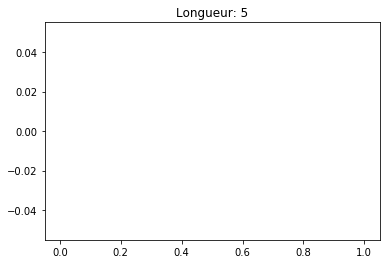

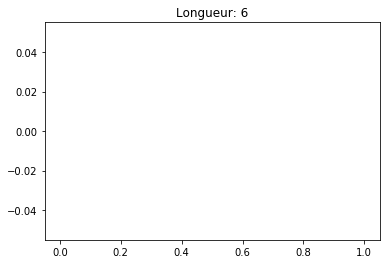

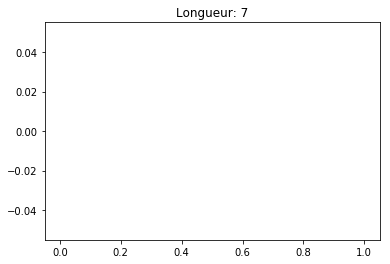

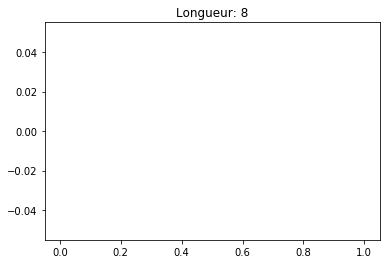

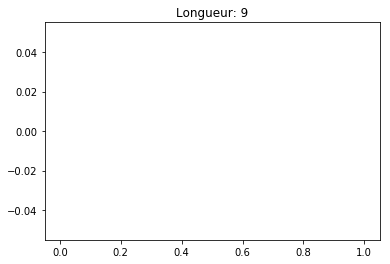

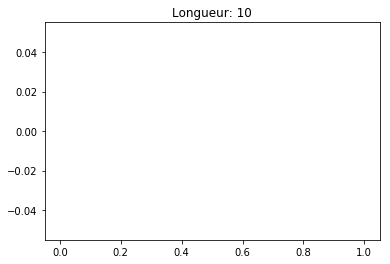

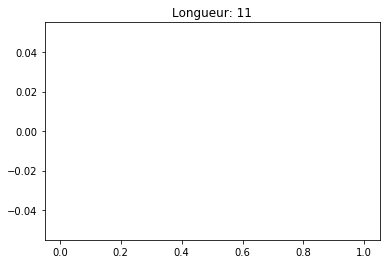

In [376]:
for k in pd.DataFrame(round(X['longueur'])).apply(pd.value_counts).index:
    plt.hist(clusters[round(X['longueur']) == k].T)
    plt.title("Longueur: " + str(k))
    plt.show()

In [ ]:
plt.scatter(X['longueur'], clusters.T)
plt.show()

In [99]:
max_ = 5

ampl_name = list_multiple_var("amplitude_", var_from=0, var_to=max_)
fwhm_name = list_multiple_var("fwhm_", var_from=0, var_to=max_)
time_name = list_multiple_var("time_", var_from=0, var_to=max_)
kind_name = list_multiple_var("kind_", var_from=0, var_to=max_)
list_var = [ampl_name, fwhm_name, time_name, kind_name]

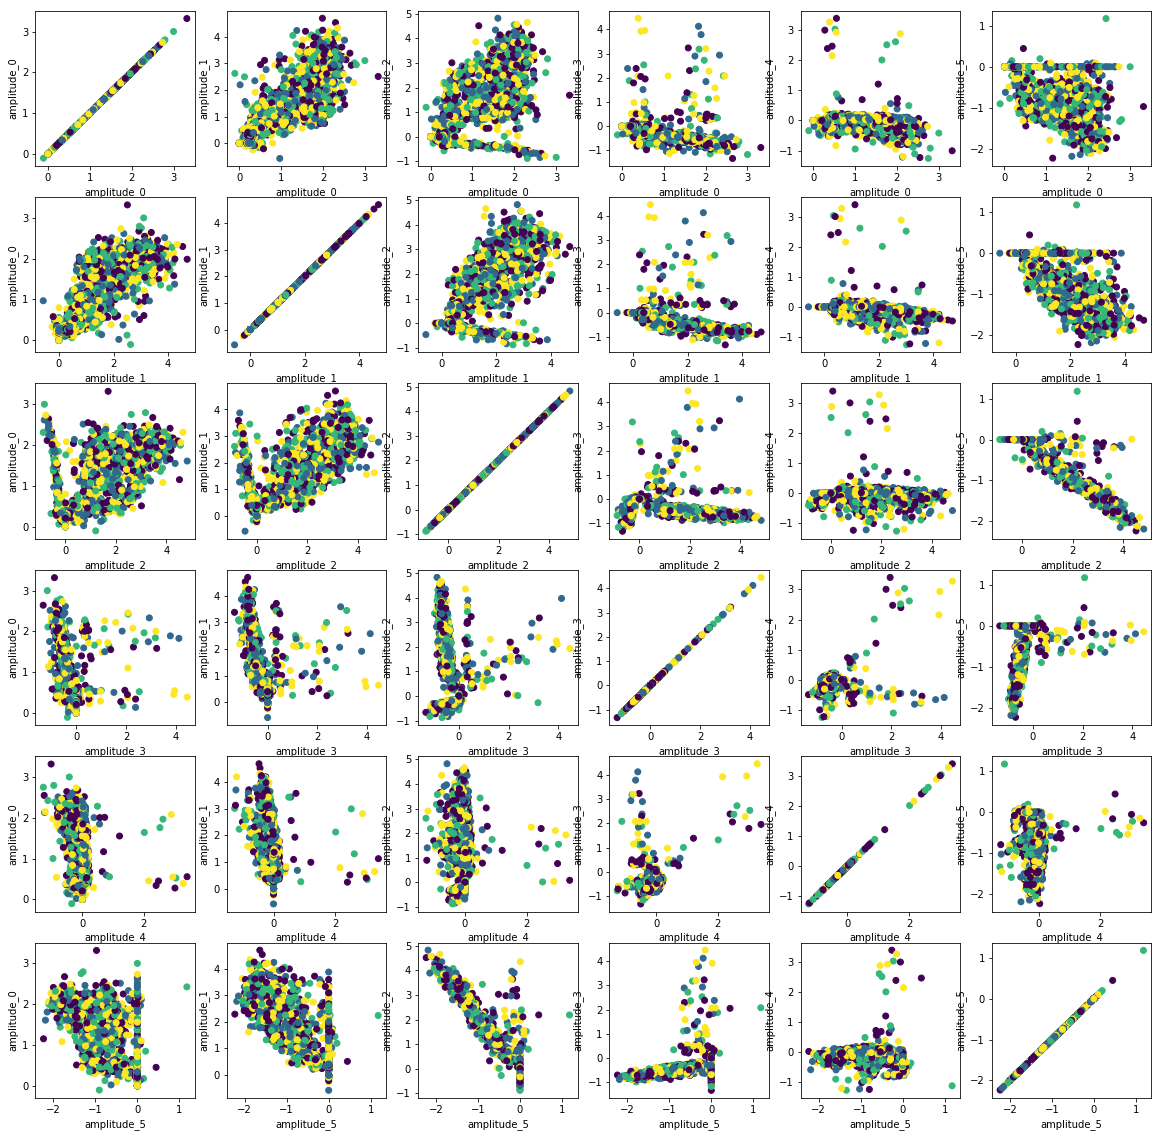

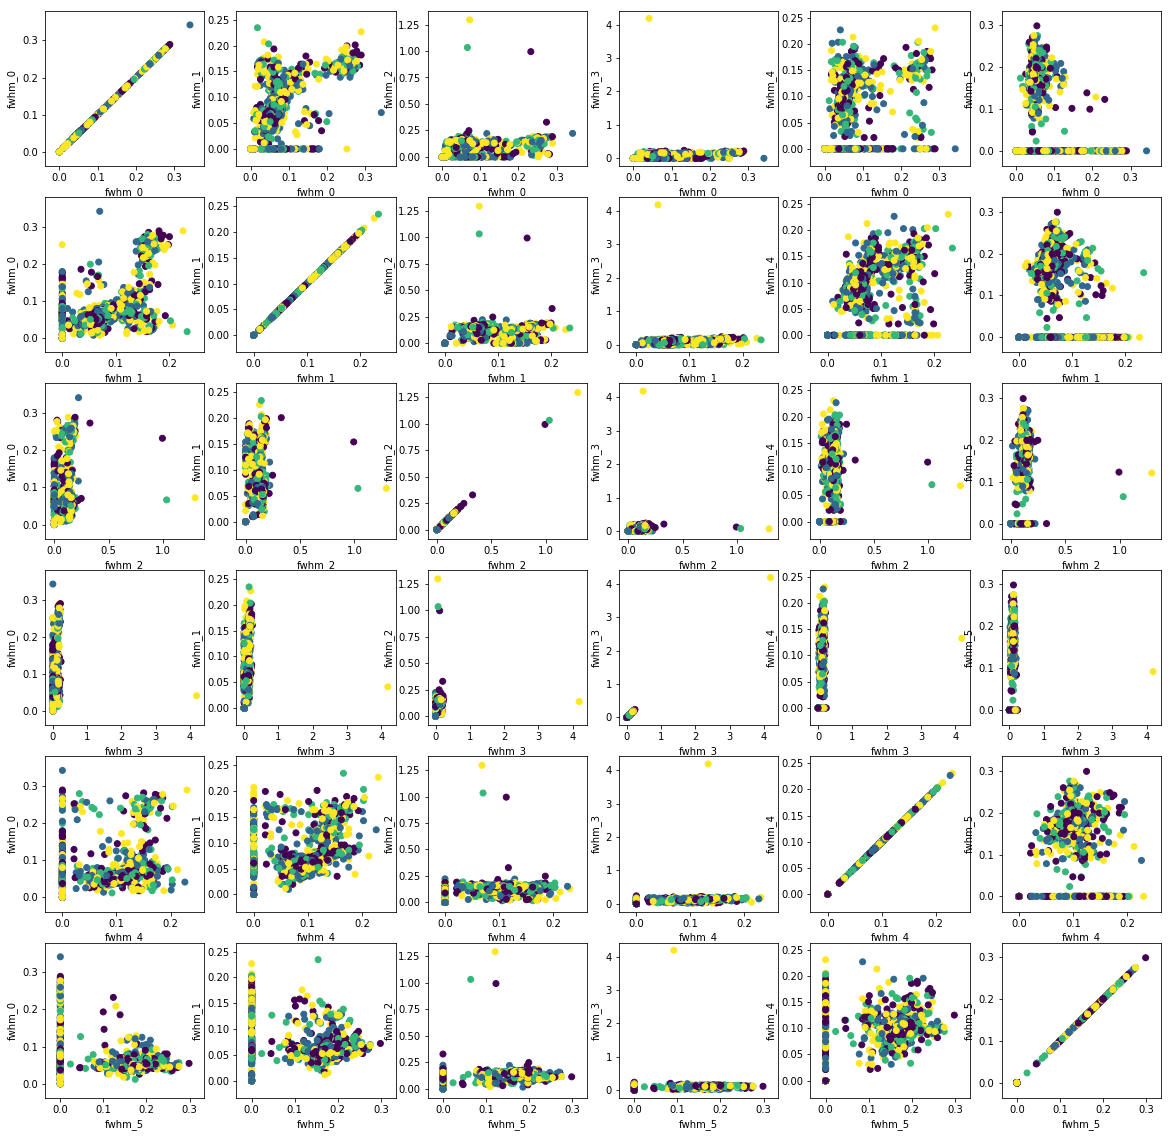

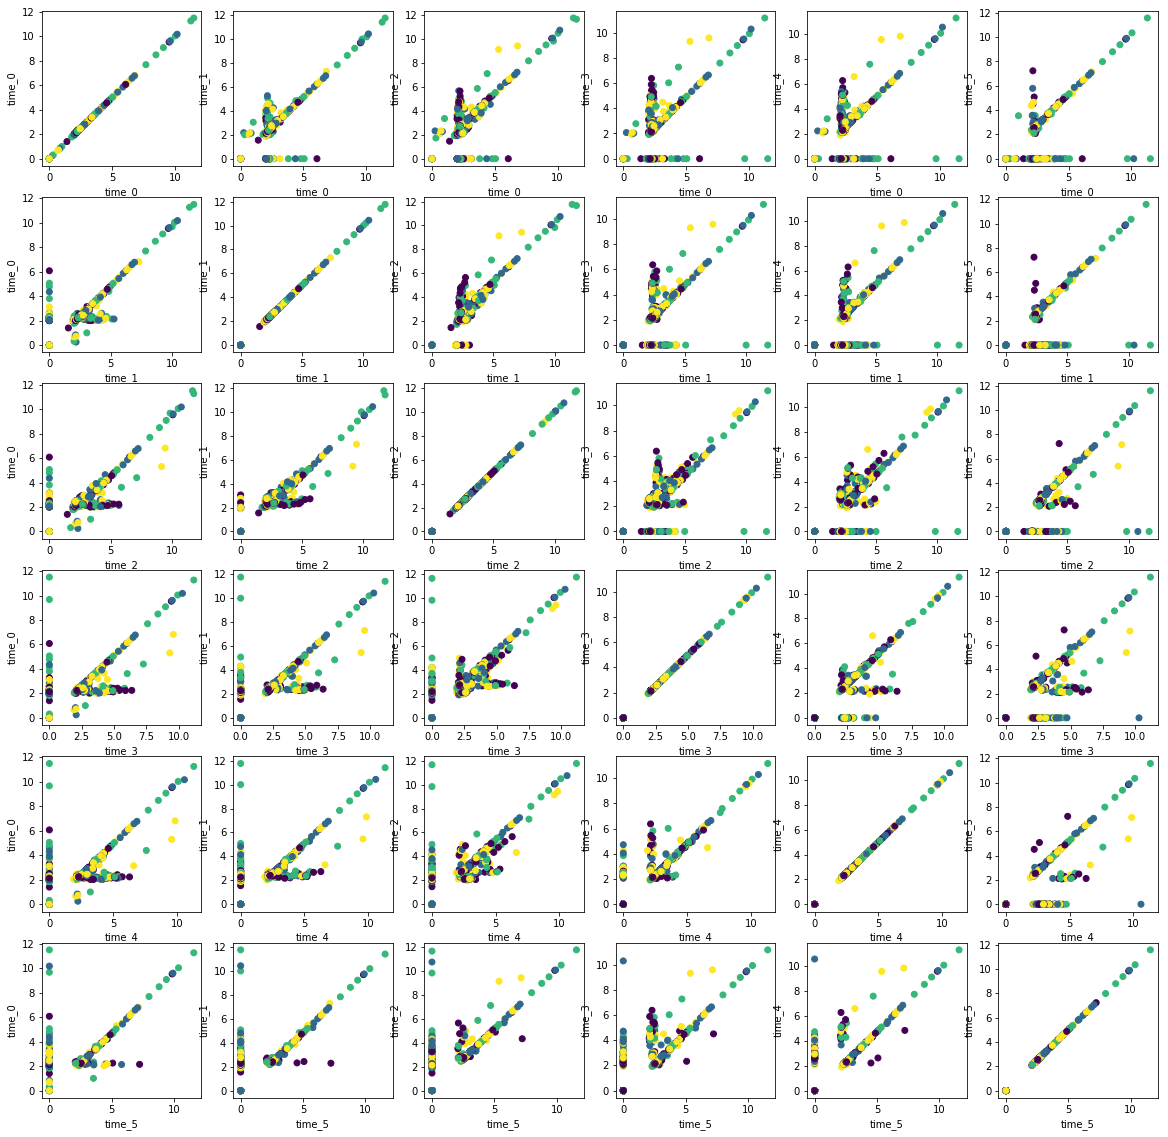

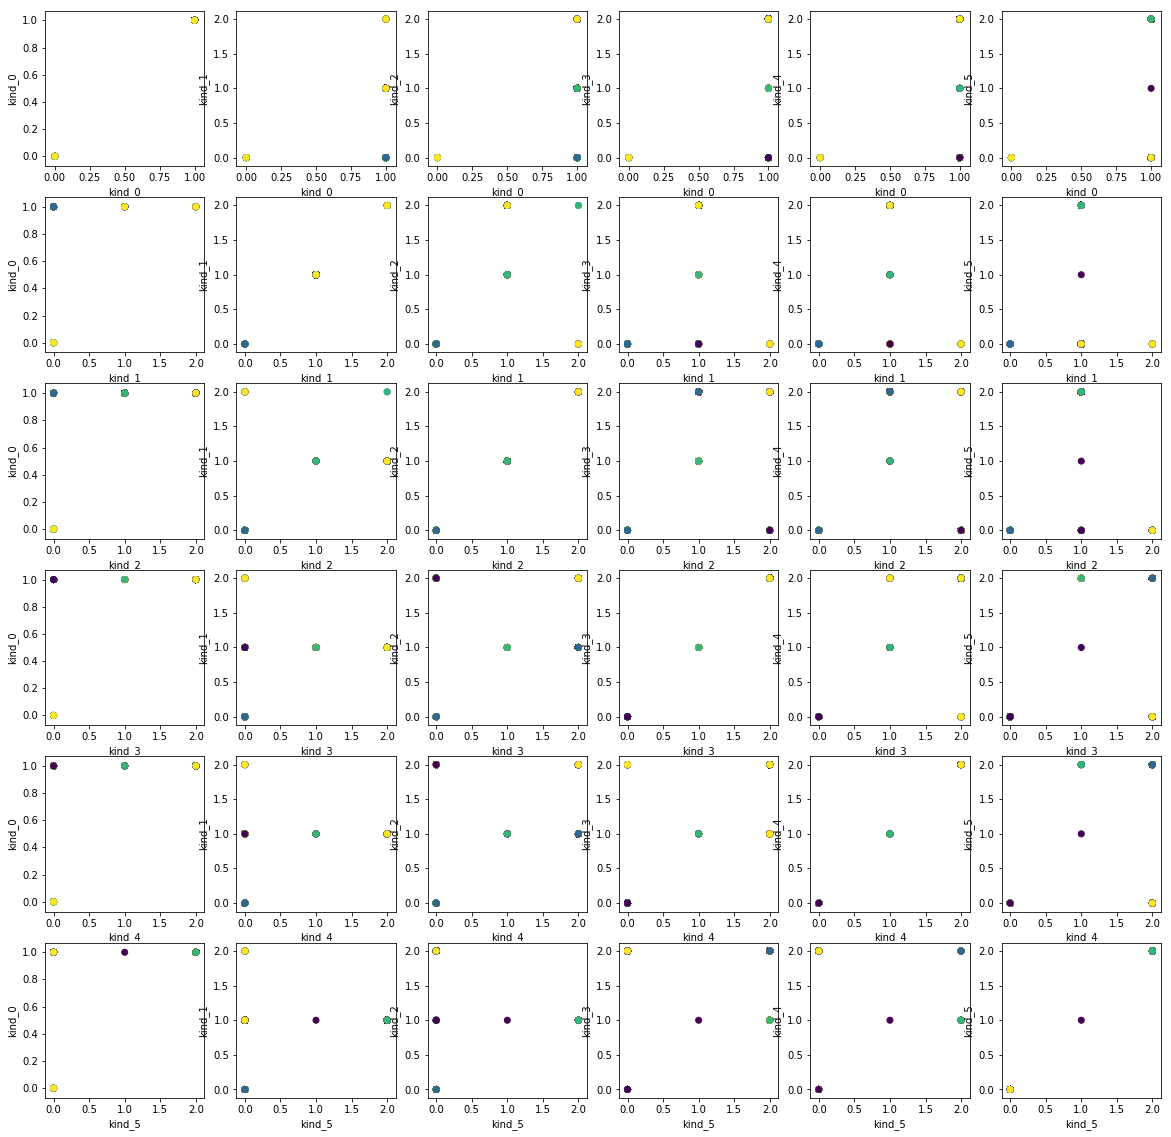

In [100]:
# Regrouppement variable par variable sur 5 élements
for var in list_var:
    plt.figure(figsize=(20,20))
    k=0
    for i in range(max_+1):
        for j in range(max_+1):
            k+=1
            plt.subplot(max_+1, max_+1, k)
            plt.scatter(X_train[var[i]], X_train[var[j]], c=predicted)
            plt.xlabel(var[i])
            plt.ylabel(var[j])

    plt.show()

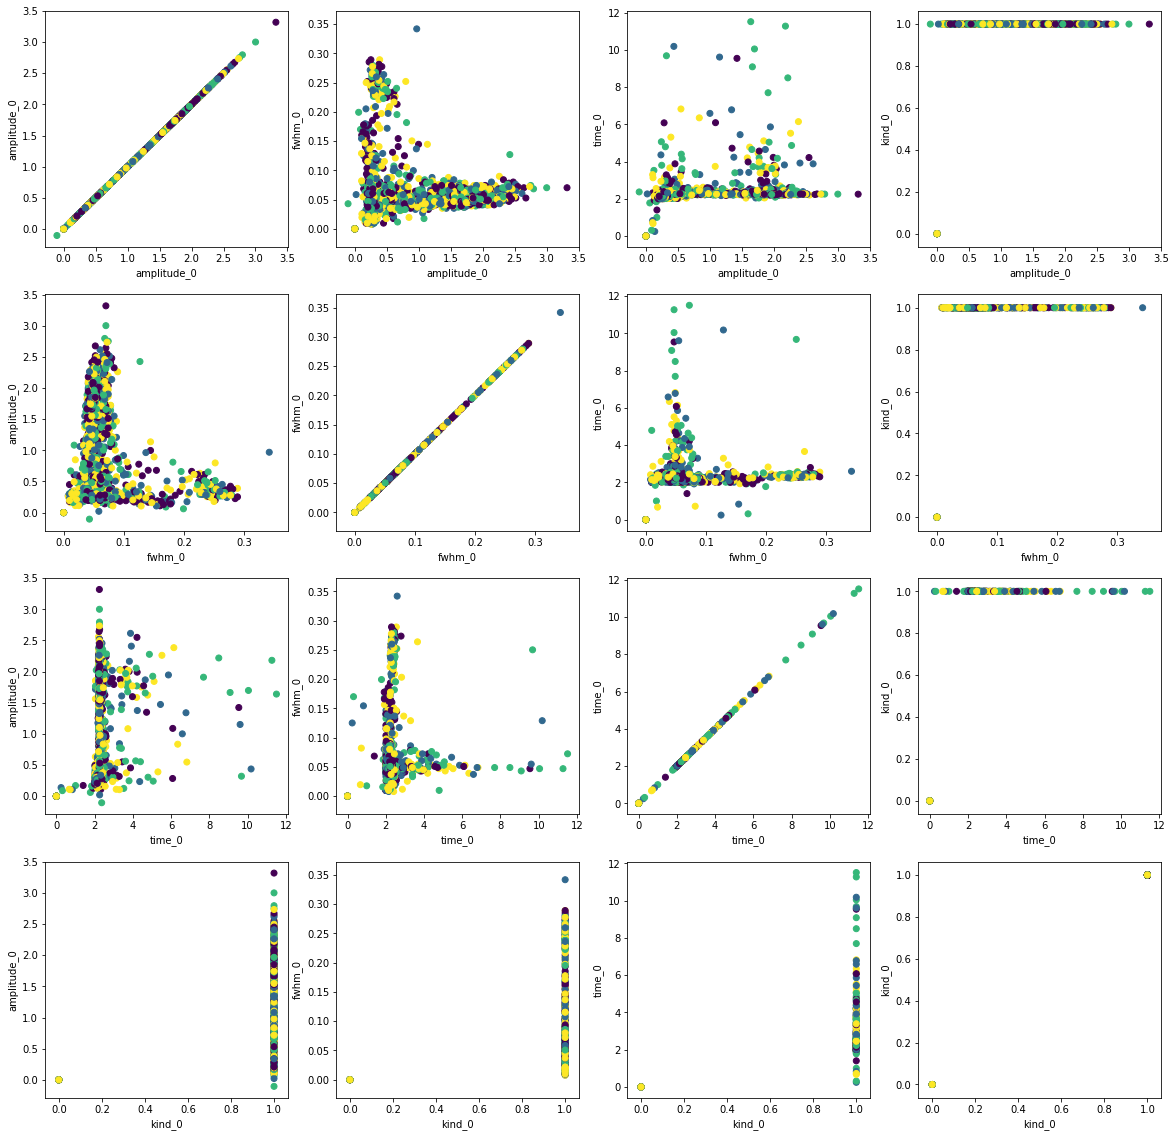

In [101]:
# Regroupement différente variables sur 1er élément
plt.figure(figsize=(20,20))
k=0
for i in list_var:
    for j in list_var:
        k+=1
        plt.subplot(len(list_var), len(list_var), k)
        plt.scatter(X_train[i[0]], X_train[j[0]], c=predicted)
        plt.xlabel(i[0])
        plt.ylabel(j[0])

plt.show()

#### Regression linéraire (Ridge)

In [493]:
rid = Ridge(random_state=42)
param = {
    "alpha" : [1.0],
    "max_iter" : [10],
    "solver" : ['saga'],
    "tol" : [0.01],
    "fit_intercept" : [False],
    "normalize" : [True],
    "copy_X" : [True]
}

In [494]:
clf = GridSearchCV(rid, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\alexandre\AppData\Local

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [1.0], 'max_iter': [10], 'solver': ['saga'], 'tol': [0.01], 'fit_intercept': [False], 'normalize': [True], 'copy_X': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [495]:
# Negate to have the MSE
-clf.best_score_

0.4039464957246841

In [496]:
clf.best_params_

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': 10,
 'normalize': True,
 'solver': 'saga',
 'tol': 0.01}

In [497]:
pred_X_train = clf.predict(X_train)
pred_X_test = clf.predict(X_test)

In [498]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test, pred_X_test))

Erreur train :  0.36784001132644345
Erreur test :  0.45028787104940127


In [499]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,0.444066,0.591251,0.479207,0.946806,0.436375,0.0,0.0,0.0,0.492796,0.580872,0.705716,0.596403,0.591444,0.004586,0.0,0.0
1,-0.035212,-0.417476,-0.410472,-0.251845,-0.492794,0.0,0.0,0.0,0.284918,0.056753,0.050725,0.102006,0.105961,0.001379,0.0,0.0
2,-0.047177,-1.085076,-0.828362,-1.044040,0.000000,0.0,0.0,0.0,-0.116336,-0.537393,-0.557994,-0.553369,-0.496417,0.007092,0.0,0.0
3,-0.383481,-0.861346,-0.942857,-1.024136,-1.114408,0.0,0.0,0.0,-0.006039,-0.442045,-0.438335,-0.530225,-0.475754,0.003261,0.0,0.0
4,0.737249,0.825947,0.223108,-0.375443,0.000000,0.0,0.0,0.0,-0.134001,-0.342398,-0.656039,-0.601815,-0.556483,-0.012317,0.0,0.0
5,0.808658,0.743341,1.511108,0.834101,0.895269,0.0,0.0,0.0,-0.446823,0.363525,0.040103,-0.026580,0.046866,-0.009946,0.0,0.0
6,-1.274611,-0.849948,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.239738,-0.352314,-0.139033,-0.127402,0.021373,0.000338,0.0,0.0
7,-0.100660,0.077373,-0.203995,-0.335911,-0.506419,0.0,0.0,0.0,0.152658,0.081152,-0.157766,-0.072967,-0.144396,0.001791,0.0,0.0
8,0.919327,1.215890,1.109592,0.434180,1.022776,0.0,0.0,0.0,0.635727,0.895832,0.639040,0.718381,0.543053,-0.003471,0.0,0.0
9,-1.993528,-1.590211,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.121282,-0.183047,-0.018989,-0.019555,-0.103426,-0.002294,0.0,0.0


#### Regression linéraire (ElasticNet)

In [500]:
elsn = ElasticNet(random_state=42)
param = {
    "alpha" : [0.09],
    "l1_ratio" : [0.1],
    "fit_intercept" : [True],
    "normalize" : [False],
    "precompute" : [True],
    "max_iter" : [15],
    "copy_X" : [True],
    "tol" : [0.001],
    "warm_start" : [True],
    "positive" : [False],
    "selection" : ['cyclic'],
}

In [501]:
clf = GridSearchCV(elsn, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\alexandre\AppData\Local\conda\conda\envs\py36\lib\site-packages\

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [0.09], 'l1_ratio': [0.1], 'fit_intercept': [True], 'normalize': [False], 'precompute': [True], 'max_iter': [15], 'copy_X': [True], 'tol': [0.001], 'warm_start': [True], 'positive': [False], 'selection': ['cyclic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [502]:
# Negate to have the MSE
-clf.best_score_

0.401913993599827

In [503]:
clf.best_params_

{'alpha': 0.09,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 15,
 'normalize': False,
 'positive': False,
 'precompute': True,
 'selection': 'cyclic',
 'tol': 0.001,
 'warm_start': True}

In [504]:
pred_X_train = clf.predict(X_train)
pred_X_test = clf.predict(X_test)

In [505]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test, pred_X_test))

Erreur train :  0.374587661266472
Erreur test :  0.44650576312625556


In [506]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,0.444066,0.591251,0.479207,0.946806,0.436375,0.0,0.0,0.0,0.438852,0.505519,0.606318,0.519888,0.498819,-0.001641,0.0,0.0
1,-0.035212,-0.417476,-0.410472,-0.251845,-0.492794,0.0,0.0,0.0,0.251912,0.058407,0.060826,0.115728,0.112171,-0.001641,0.0,0.0
2,-0.047177,-1.085076,-0.828362,-1.044040,0.000000,0.0,0.0,0.0,-0.082443,-0.453717,-0.489023,-0.509573,-0.435270,-0.001641,0.0,0.0
3,-0.383481,-0.861346,-0.942857,-1.024136,-1.114408,0.0,0.0,0.0,-0.028539,-0.379291,-0.396103,-0.477421,-0.416692,-0.001641,0.0,0.0
4,0.737249,0.825947,0.223108,-0.375443,0.000000,0.0,0.0,0.0,-0.138952,-0.251610,-0.523490,-0.536960,-0.477542,-0.001641,0.0,0.0
5,0.808658,0.743341,1.511108,0.834101,0.895269,0.0,0.0,0.0,-0.297793,0.307965,-0.162771,-0.136764,-0.142171,-0.001641,0.0,0.0
6,-1.274611,-0.849948,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.281222,-0.341635,-0.117631,-0.123115,-0.010210,-0.001641,0.0,0.0
7,-0.100660,0.077373,-0.203995,-0.335911,-0.506419,0.0,0.0,0.0,0.139352,0.136463,-0.128244,-0.063622,-0.111044,-0.001641,0.0,0.0
8,0.919327,1.215890,1.109592,0.434180,1.022776,0.0,0.0,0.0,0.571873,0.828429,0.573867,0.662559,0.503794,-0.001641,0.0,0.0
9,-1.993528,-1.590211,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.166486,-0.181600,0.018838,0.016124,-0.075718,-0.001641,0.0,0.0


#### Arbre de décision (RandomForestRegressor)

In [507]:
rfr = RandomForestRegressor(random_state=42)
param = {
    "n_estimators" : [4000],
    "criterion" : ["mse"],
    "max_features" : [0.5],
    "max_depth": [20],
    "min_samples_split" : [2],
    "min_samples_leaf" : [2],
    "oob_score" : [True],
    "warm_start" : [True],
    "bootstrap" : [True]
}

In [508]:
clf = GridSearchCV(rfr, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [4000], 'criterion': ['mse'], 'max_features': [0.5], 'max_depth': [20], 'min_samples_split': [2], 'min_samples_leaf': [2], 'oob_score': [True], 'warm_start': [True], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [509]:
# Negate to have the MSE
-clf.best_score_

0.32622296006607937

In [510]:
clf.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 4000,
 'oob_score': True,
 'warm_start': True}

In [511]:
pred_X_train = clf.predict(X_train)
pred_X_test = clf.predict(X_test)

In [512]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test, pred_X_test))

Erreur train :  0.0873511284049957
Erreur test :  0.357395218870859


In [513]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_1,load_2,load_3,load_4,load_5,load_6,load_7,load_8,0,1,2,3,4,5,6,7
0,0.444066,0.591251,0.479207,0.946806,0.436375,0.0,0.0,0.0,0.613402,0.847410,1.085351,0.921420,0.869060,0.000181,0.0,0.0
1,-0.035212,-0.417476,-0.410472,-0.251845,-0.492794,0.0,0.0,0.0,0.444223,0.681739,0.518935,0.545084,0.398130,-0.000866,0.0,0.0
2,-0.047177,-1.085076,-0.828362,-1.044040,0.000000,0.0,0.0,0.0,-0.254193,-1.056787,-0.708205,-0.953197,-0.159087,0.000000,0.0,0.0
3,-0.383481,-0.861346,-0.942857,-1.024136,-1.114408,0.0,0.0,0.0,-0.330135,-0.883172,-0.957169,-1.030550,-0.968481,0.000166,0.0,0.0
4,0.737249,0.825947,0.223108,-0.375443,0.000000,0.0,0.0,0.0,-0.734711,-0.548428,-0.225143,-0.243429,-0.197354,-0.000302,0.0,0.0
5,0.808658,0.743341,1.511108,0.834101,0.895269,0.0,0.0,0.0,-0.354391,-0.021823,0.213580,0.100080,0.192215,-0.002054,0.0,0.0
6,-1.274611,-0.849948,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.609729,-0.498752,-0.126320,-0.110644,-0.076926,0.000000,0.0,0.0
7,-0.100660,0.077373,-0.203995,-0.335911,-0.506419,0.0,0.0,0.0,0.315780,0.227010,-0.262732,-0.131723,-0.297174,-0.000423,0.0,0.0
8,0.919327,1.215890,1.109592,0.434180,1.022776,0.0,0.0,0.0,0.588024,0.890819,0.932964,0.967971,0.850890,0.000029,0.0,0.0
9,-1.993528,-1.590211,0.000000,0.000000,0.000000,0.0,0.0,0.0,-0.070292,-0.438493,-0.531539,-0.667535,-0.641715,-0.000317,0.0,0.0


#### XGBoost

In [514]:
xgbr = xgb.XGBRegressor(random_state=42, n_jobs=2)
multioutpoutregressor = MultiOutputRegressor(xgbr)
param = {
    "estimator__max_depth": [1, 3, 10],
    "estimator__learning_rate": [0.01, 0.1, 1],
    "estimator__n_estimators": [150],
    "estimator__silent": [True, False],
    "estimator__objective": ['reg:linear'],
    "estimator__booster": ['gbtree', 'gblinear', 'dart'],
    "estimator__gamma": [0, 1, 10],
    "estimator__min_child_weight": [1, 5, 10],
    "estimator__max_delta_step": [0, 5, 10],
    "estimator__subsample": [0, 0.5, 0.9],
    "estimator__colsample_bytree": [0.1, 0.5, 1],
    "estimator__colsample_bylevel": [0.1, 0.5, 1],
    "estimator__reg_alpha": [0, 10],
    "estimator__reg_lambda": [1, 10],
    "estimator__scale_pos_weight": [1, 10],
    "estimator__base_score": [0, 0.5, 1]
}

In [ ]:
clf = GridSearchCV(multioutpoutregressor, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

In [ ]:
# Negate to have the MSE
-clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
pred_X_train = clf.predict(X_train)
pred_X_test = clf.predict(X_test)

In [ ]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test, pred_X_test))

In [ ]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)